In [1]:
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.callbacks import *
from keras import regularizers
from keras import optimizers
# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score,fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.datasets import make_classification  
from sklearn.decomposition import PCA
import sys
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
# other
import time
import csv

In [2]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [3]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [4]:
#dftrain1=df_train_orig.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'])
#dftrain2=df_test_01.drop([' S_PU1',' S_PU2',' S_PU3',' S_PU4',' S_PU5',' S_PU6',' S_PU7',' S_PU8', ' S_PU9',' S_PU10',' S_PU11',' S_V2'])
#dftest=df_test_02.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'])

In [5]:
#sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]
dftrain1=df_train_orig.set_index('DATETIME')
dftrain2=df_test_01.set_index('DATETIME')
dftest=df_test_02.set_index('DATETIME')
#scaler = MinMaxScaler()
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']

In [6]:
train1_=dftrain1
train2_=dftrain2
test_=dftest
train1_.iloc[:,range(0,31)]=preprocessing.scale(dftrain1.iloc[:,range(0,31)])
train2_.iloc[:,range(0,31)]=preprocessing.scale(dftrain2.iloc[:,range(0,31)])
test_.iloc[:,range(0,31)]=preprocessing.scale(dftest.iloc[:,range(0,31)])

In [7]:
#Creating the function
def pca_reverse_trasformation(n_components,random_state,df):
    #Creating PCA model
    pca = PCA(n_components=n_components, whiten=False, random_state=random_state)
    #Applyting PCA transformation to dataset
    df_PCA = pca.fit_transform(df)
    #Saving in a dataframe format
    df_PCA = pd.DataFrame(data=df_PCA, index=df.index)
    #Reversing the PCA
    df_PCA_inverse = pca.inverse_transform(df_PCA)
    #Saving in a dataframe format
    df_PCA_inverse = pd.DataFrame(data=df_PCA_inverse,index=df.index)
    return df_PCA_inverse

#Applying the function
n_components = 10
random_state = 27
df=train1_
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

In [8]:
def residuals_pca(original_column,pca_column):
    #Creating DF with the selected column from the transformed dataset
    PCA_df=pd.DataFrame(data=pca_column,index=pca_column.index)
    PCA_df.columns = ['transformed']
    PCA_df["original"]=original_column
    #Calculating the residuals
    PCA_df["residuals"]=PCA_df["original"]-PCA_df['transformed']
    return  PCA_df

In [9]:
def AnomalyScore(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    #Scaling between 0 and 1
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [10]:
def AnomalyValue(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    return loss

In [11]:
def pca_predict(dataset,truelabels,n_pca_components,threshold,Anomaly="Scores"):
   
    #One random number was picked for the random state
    random_state=27
    ###Generating the model for the data set###
    dataset_PCA_inverse=pca_reverse_trasformation(n_pca_components,random_state,dataset)

    ###Anomaly scores
    if Anomaly=="Scores":
        #Using anomaly scores
        AnomalyScoresPCA=AnomalyScore(dataset, dataset_PCA_inverse)
        AnomalyScoresPCA=pd.Series.to_frame(AnomalyScoresPCA)
        AnomalyScoresPCA.columns=["AnomalyScore"]
    else:
        ###Using Anomaly values
        AnomalyScoresPCA=AnomalyScore(dataset, dataset_PCA_inverse)
        AnomalyScoresPCA=pd.Series.to_frame(AnomalyScoresPCA)
        AnomalyScoresPCA.columns=["AnomalyScore"]
    
    ###Predicting
    AnomalyScoresPCA['predictions']=AnomalyScoresPCA['AnomalyScore'].apply(lambda x: 1 if x>threshold else 0)
    
    ###Calculating the performance
    cm=confusion_matrix(list(truelabels), list(AnomalyScoresPCA['predictions']))
    if cm.shape==(3,3):
        cm=cm[(0,2),1:]
    #True positive, false positive, false negative and true positive
    tn, fp, fn, tp = cm.ravel()
    #Getting the ratios
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    #F-score
    F_score=fbeta_score(list(truelabels), list(AnomalyScoresPCA['predictions']), beta=0.5)
    #Probability vector
    performance={"recall":recall,"precision":precision,"Accuracy":accuracy,"F_score":F_score}
    return cm,performance,AnomalyScoresPCA['predictions']

In [12]:
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix - PCA'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])

([<matplotlib.axis.XTick at 0x25b557b2850>,
 <a list of 41 Text major ticklabel objects>)

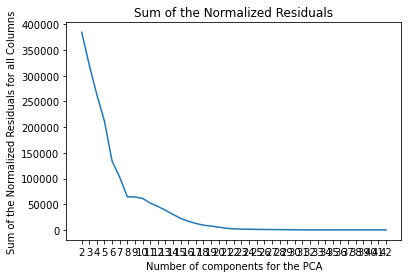

In [13]:
#Assigning random state
random_state = 27
#Creating dictinary to get all the sum of residuals for component
SumOfResiduals=dict()
#The dataframe that will be used for the model
df=train1_

#Looping through all the columns and getting the sum of residuals
for n_components in range(2,int(len(df.columns)-1)):
    dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)
    Sum_for_all_col=0
    for col in df.columns:
        Sum_for_all_col+=sum(residuals_pca(df[col],dftrain1_PCA_inverse[df.columns.get_loc(col)])['residuals'].apply(lambda x: abs(x)))
    SumOfResiduals[n_components]=Sum_for_all_col
    
#Ploting the sum of residuals
lists = sorted(SumOfResiduals.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Sum of the Normalized Residuals')
plt.xlabel('Number of components for the PCA')
plt.ylabel('Sum of the Normalized Residuals for all Columns')
plt.xticks(x)

In [14]:
n_components=19
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)
df=train1_

Text(0, 0.5, 'Anomaly Values')

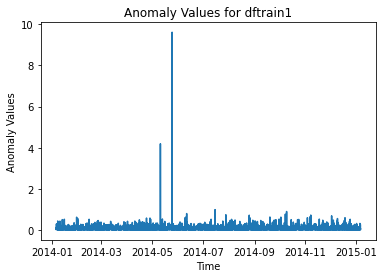

In [15]:
#Calculating anomaly values
anomaly_values=AnomalyValue(df, dftrain1_PCA_inverse)
# Getting the threshold
threshold_dftrain1=np.percentile(np.array(anomaly_values), 80, axis=0)
#Ploting the anomalous values
plt.plot(anomaly_values)
plt.title('Anomaly Values for dftrain1')
plt.xlabel('Time')
plt.ylabel('Anomaly Values')

In [16]:
def save_valid_label(arr, csv_filename=None):
    """Save the data in csv format"""
    if csv_filename == None:
        csv_filename="valid_label.csv"
    arr_df = pd.DataFrame(arr)
    arr_df.to_csv(csv_filename, float_format='%.3f', index=False, header=False)


In [17]:
def save_test_label(arr, csv_filename=None):
    """Save the data in csv format"""
    if csv_filename == None:
        csv_filename="test_label.csv"
    arr_df = pd.DataFrame(arr)
    arr_df.to_csv(csv_filename, float_format='%.3f', index=False, header=False)

{'recall': 0.03048780487804878, 'precision': 0.8823529411764706, 'Accuracy': 0.8853243954991621, 'F_score': 0.13392857142857142}


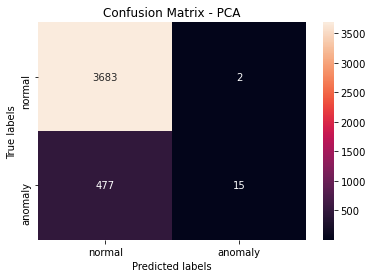

In [18]:
dataset=train2_.drop(['ATT_FLAG'],axis=1)
truelabels=df_test_01['ATT_FLAG']
n_pca_components=19
threshold=threshold_dftrain1
cm,performance,predictions=pca_predict(dataset,truelabels,n_pca_components,threshold,Anomaly="values")
#predictions = pd.DataFrame(predictions)

save_valid_label(predictions)
Yhat3 = pd.read_csv(data_path + "valid_label.csv")
#valid_pred = predictions.drop(['DATATIME'],axis=1)
ploting_cm(cm)
#(pd.DataFrame(PCA_model_trainset2)).drop(['DATATIME'],axis=1)
#print(PCA_model_trainset2[1])
print(performance)
#print(predictions)

In [19]:
dataset1=test_.drop(['ATT_FLAG'],axis=1)
truelabels1=df_test_02['ATT_FLAG']
n_pca_components=19
threshold=threshold_dftrain1
cm1,performance1,predictions1=pca_predict(dataset1,truelabels1,n_pca_components,threshold,Anomaly="values")

{'recall': 0.10319410319410319, 'precision': 1.0, 'Accuracy': 0.8252752513164193, 'F_score': 0.3652173913043478}


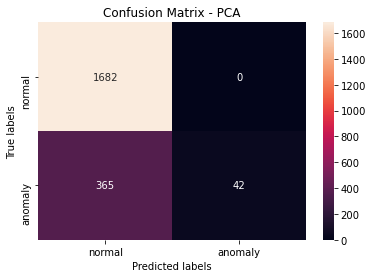

In [20]:
save_test_label(predictions1)
Yhat4 = pd.read_csv(data_path + "test_label.csv")
ploting_cm(cm1)
print(performance1)

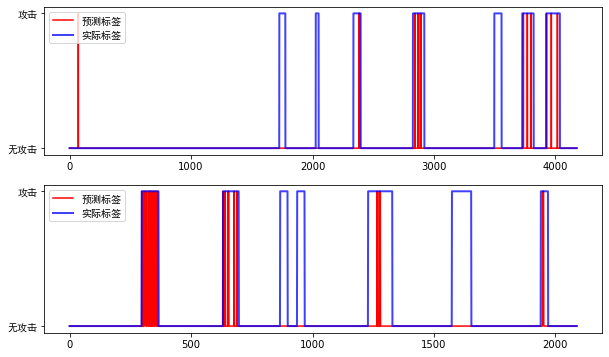

<Figure size 432x288 with 0 Axes>

In [21]:
# plot figures
font2 = {'family' : 'SimHei',#Times New Roman
        'weight' : 'normal',
        'size'   : 10,
            }
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 6,
            }
shade_of_gray = '0.5'
f_PCA, axes = plt.subplots(2,figsize = (10,6))
axes[0].plot(Yhat3, color = 'r', label = '预测标签')#shade_of_gray
#axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color='r')
axes[0].plot(Y3, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[0].set_title('validation set', font2,loc='left')
#axes[0].set_xlabel('Time/h',font2)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['无攻击','攻击'],font2)
axes[0].legend(loc='upper left',prop=font2)
#axes[0].legend(fontsize = 12, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

axes[1].plot(Yhat4, color = 'r', label = '预测标签')
#axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color='r')
axes[1].plot(Y4, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[1].set_title('test set', font2,loc='left')
#axes[1].set_xlabel('Time/h',font2)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['无攻击','攻击'],font2
axes[1].set_xlabel('Time/h',font2)
axes[1].legend(loc='upper left',prop=font2)
#axes[1].legend(fontsize = 12, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

plt.savefig("f_PCA3.png", dpi=1000, bbox_inches = 'tight')

plt.show()

plt.clf()

In [ ]:
cm_plot(Y3,Yhat3)
cm_plot(Y4,Yhat4)